In [105]:
import pandas as pd
import numpy as np
import re

import statsmodels.api as sm

from sklearn.metrics import r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

import scipy.optimize as sco

from sklearn.linear_model import LinearRegression

import matplotlib.pyplot as plt

In [106]:
df = pd.read_csv('/Users/msstark/Desktop/Brandeis/Field Project/code/FullData2.csv').drop('Unnamed: 0',axis = 1)
df.head()

,Date,bcom_ret,cpi_ret,pmi_ret,dxy_ret,Materials_ret,_Industrials_ret,_Consumer_Discretionary_ret,Consumer_Staples_ret,_Health_Care_ret,Financials_ret,Information_Technology_ret,Telecommunication_Services__ret,Utilities_ret,Real_Estate_ret,Energy_ret
0,1995-01-31,-0.010776,0.002003,-0.040070,-0.009804,0.064244,0.052688,0.033880,0.028613,0.011563,0.052696,0.066760,0.005734,0.000942,-0.011090,0.031235
1,1995-02-28,-0.005805,0.002665,-0.054446,-0.021737,0.053224,0.033088,0.030175,0.028865,0.027695,0.001254,0.050385,0.002281,-0.022580,-0.006164,0.050957
2,1995-03-31,0.019684,0.002658,-0.011516,-0.048744,0.012541,0.030675,-0.013433,0.028333,0.024959,0.033539,0.105226,0.021426,0.027722,0.036709,0.027098
3,1995-04-30,0.015482,0.001988,-0.093204,0.002079,0.029633,0.021884,0.044629,0.043040,0.022940,0.074939,0.037986,-0.007054,0.065561,0.014088,0.029913
4,1995-05-31,-0.012037,0.003968,-0.017131,0.007689,0.036621,0.015762,0.026340,0.016143,0.041401,0.003703,0.090244,0.027482,-0.015030,0.007169,-0.036326


In [107]:
df.shape

(327, 16)

In [108]:
# function to estimate the root of mean squared error
def RMSE(yActual,yPred):
    sr  = np.square(yActual - yPred)
    msr = np.mean(sr)
    return np.sqrt(msr)

In [109]:
def MultiReg_prep(data,x_name,y_name,n_input,n_output,interact):
    data = data[data[y_name].isna()==False].copy().reset_index().drop('index',axis = 1)
    in_start = 0
    X, y     = [], []
    for _ in range(len(data)):
        # independent(input) ending point
        in_end  = in_start + n_input - 1.
        # dependent (output) ending point
        out_end = in_end + n_output
        # make sure we have enough data at the end
        if out_end < len(data):
            x_input = data.loc[in_start:in_end, x_name].to_numpy()
            # add interaction terms if required
            if interact == True:
                # only keep interation terms and delete the bias column (a column of 1)
                poly    = PolynomialFeatures(interaction_only=True,include_bias = False)
                # using this poly feature to fit and transform x
                x_input = poly.fit_transform(x_input)    
            X.append(x_input)
            # in_start+n_output because we need to select the data 1 month later than input 
            # to avoid looking forward bias
            y.append(data.loc[in_start+n_output:out_end, y_name])
        # moving 1 month forward
        in_start += 1
    return X,y

In [110]:
def rolling_MultiReg(X,Y,threshold,regularization):
    R2        = []
    y_predIn  = []
    y_predOut = []
    RMSEIn    = []
    RMSEOut   = []
    coefficients = []

    # iterate through our prepared dataset fitting the model and making predictions
    for i in range(len(X)):
        x = X[i]
        x = sm.add_constant(x)
        y = Y[i]
        
        # if regularization == False, means we don't want reduce the dimension in our predictors, then
        # the model is just a single linear regression
        if regularization == False:
            model = LinearRegression()  
        # Otherwise, we can use the function above to choose the number of components first
        # Then our model will equal to the pipeline down below, standardize --> PCA --> linear regression 
        else:
            ncomponent = find_component(x,threshold)
            model      = Pipeline([('scaler',StandardScaler()),
                                   ('pca',PCA(n_components = ncomponent)),
                                   ('lr',LinearRegression())])
        # regression
        multi_reg    = model.fit(x,y)
        
        # get coefficient
        coef = multi_reg.coef_[1]
        coefficients.append(coef)        
        
        # In sample prediction
        multi_predIn = multi_reg.predict(x)
        y_predIn.append(multi_predIn)
        
        # Record the R2 for each fitting
        r2_multi    = multi_reg.score(x,y)
        R2.append(r2_multi)
        
        # calculate the In sample Root of mean squared error
        RMSEIn.append(RMSE(y,multi_predIn))    
        # using the next period data as out of sample predictors to make prediction
        # -1 because the last set of data doesn't have a next period
        if i < len(X)-1:
            # Making predictions
            multi_predOut = multi_reg.predict(sm.add_constant(X[i+1]))
            y_predOut.append(multi_predOut[-1])
            # Record the out of sample mean squared error
            RMSEOut.append(RMSE(Y[i+1],multi_predOut))  
    return R2, y_predIn, y_predOut, RMSEIn, RMSEOut, coefficients

In [148]:
cols      = df.columns[5:]
ind_cols  = ['bcom_ret','cpi_ret','pmi_ret','dxy_ret']
T1        = 216
results7  = {}
R_squared = {}
predictionsIn  = {}
predictionsOut = {}
Coeffs = {}


for i in range(len(cols)):
    X_array7,y_array7 = MultiReg_prep(df,ind_cols,cols[i],n_input = T1,n_output = 1,interact = False)
    R2, y_predIn, y_predOut, RMSEIn, RMSEOut, Coefficients = rolling_MultiReg(X_array7,y_array7,threshold = 0,regularization = False)
    results7[i] = [RMSEIn, RMSEOut]
    R_squared[cols[i]] = R2
    predictionsIn[cols[i]]  = y_predIn
    predictionsOut[cols[i]] = y_predOut
    Coeffs[cols[i]] = Coefficients
    
    
    print(cols[i])
    print('Mean of R-squared: ',np.mean(R2))
    print('IS RMSE: ',np.mean(RMSEIn))
    print('OOS RMSE: ',np.mean(RMSEOut))
    print('\n')

Materials_ret
Mean of R-squared:  0.038307561864257156
IS RMSE:  0.05854622271736139
OOS RMSE:  0.05852506124828059


_Industrials_ret
Mean of R-squared:  0.056706080787612946
IS RMSE:  0.05080152795525919
OOS RMSE:  0.05079123028830524


_Consumer_Discretionary_ret
Mean of R-squared:  0.031051100305146816
IS RMSE:  0.051546181367356995
OOS RMSE:  0.05153167617664215


Consumer_Staples_ret
Mean of R-squared:  0.04016554690728417
IS RMSE:  0.03330587891007316
OOS RMSE:  0.0332772953036375


_Health_Care_ret
Mean of R-squared:  0.03190557316377368
IS RMSE:  0.03968404815586869
OOS RMSE:  0.03965216128948094


Financials_ret
Mean of R-squared:  0.08664204276985477
IS RMSE:  0.06065196891383257
OOS RMSE:  0.06062053383928407


Information_Technology_ret
Mean of R-squared:  0.02596860867210328
IS RMSE:  0.067718033726113
OOS RMSE:  0.06761165960613533


Telecommunication_Services__ret
Mean of R-squared:  0.025122050624384478
IS RMSE:  0.05521403638054226
OOS RMSE:  0.05517815070495456


Uti

### Construct a dataframe to store the predicted sector return each month

In [149]:
Retdf = pd.DataFrame.from_dict(predictionsOut, orient='index').transpose()
Retdf.head()

,Materials_ret,_Industrials_ret,_Consumer_Discretionary_ret,Consumer_Staples_ret,_Health_Care_ret,Financials_ret,Information_Technology_ret,Telecommunication_Services__ret,Utilities_ret,Real_Estate_ret,Energy_ret
0,0.012154,0.008973,0.009965,0.008413,0.009115,0.013820,0.014901,0.004314,0.001013,0.010741,0.010231
1,-0.000676,0.004049,0.007324,0.000859,0.006794,-0.005283,0.011002,0.004972,0.007203,-0.001563,0.006768
2,0.003534,0.012736,0.011415,0.009247,0.013118,0.006357,0.009259,0.009134,0.010656,0.006524,0.014917
3,-0.005721,-0.013478,-0.000350,-0.004122,-0.004019,-0.018273,0.006168,-0.001221,-0.002751,-0.015700,-0.012733
4,0.011073,0.004390,0.008252,0.003746,0.006333,0.008754,0.016776,0.002247,0.001112,0.010991,0.006696


In [150]:
Retdf.shape

(110, 11)

In [151]:
Retdf.isna().sum()

Materials_ret                      0
_Industrials_ret                   0
_Consumer_Discretionary_ret        0
Consumer_Staples_ret               0
_Health_Care_ret                   0
Financials_ret                     0
Information_Technology_ret         0
Telecommunication_Services__ret    0
Utilities_ret                      0
Real_Estate_ret                    0
Energy_ret                         0
dtype: int64

### Construct a dataframe to store the regression coefficient each month

In [152]:
Coefdf = pd.DataFrame.from_dict(Coeffs, orient='index').transpose()
Coefdf.head()

,Materials_ret,_Industrials_ret,_Consumer_Discretionary_ret,Consumer_Staples_ret,_Health_Care_ret,Financials_ret,Information_Technology_ret,Telecommunication_Services__ret,Utilities_ret,Real_Estate_ret,Energy_ret
0,0.161326,0.217619,0.179864,0.117688,0.165514,0.280129,0.203855,0.185472,0.065387,0.137867,0.149679
1,0.163895,0.219268,0.181781,0.119623,0.167676,0.281035,0.205753,0.185961,0.065374,0.138114,0.152167
2,0.164831,0.221354,0.180427,0.120314,0.168301,0.282799,0.211015,0.185666,0.065279,0.139232,0.154299
3,0.168306,0.224973,0.184108,0.120837,0.169743,0.291821,0.215475,0.180491,0.063402,0.136715,0.156724
4,0.170106,0.223326,0.181621,0.119192,0.166661,0.291350,0.214542,0.176551,0.063799,0.135112,0.159841


In [153]:
Coefdf.shape

(111, 11)

### Construct a dataframe to store the model R-squared each month

In [154]:
R2df = pd.DataFrame.from_dict(R_squared, orient='index').transpose()
R2df.head()

,Materials_ret,_Industrials_ret,_Consumer_Discretionary_ret,Consumer_Staples_ret,_Health_Care_ret,Financials_ret,Information_Technology_ret,Telecommunication_Services__ret,Utilities_ret,Real_Estate_ret,Energy_ret
0,0.023991,0.045538,0.019168,0.034399,0.028461,0.062166,0.014570,0.018468,0.008608,0.058959,0.044473
1,0.025503,0.046567,0.019672,0.035449,0.029082,0.062570,0.014826,0.018497,0.008159,0.058875,0.046056
2,0.025943,0.047931,0.019325,0.035242,0.029516,0.063684,0.015955,0.018688,0.008947,0.059726,0.047257
3,0.026518,0.049305,0.020490,0.035251,0.030210,0.066067,0.016507,0.017486,0.007550,0.059930,0.048334
4,0.029145,0.049937,0.020111,0.035880,0.030479,0.067292,0.016385,0.016753,0.007780,0.061604,0.048009


In [155]:
R2df.shape

(111, 11)

## Information Coefficient

In [156]:
def info_coef(df1,df2):
    # total length of the dataframe
    T = df1.shape[0]
    # Information Coefficient at each time point
    ICt = []
    for i in range(T):
        # sector return in each month
        ret  = df1.iloc[i].dropna().to_numpy()
        
        # ranking for each sector based on the correlation coefficient
        rank = df2.iloc[i][df1.iloc[i].isna()==False].rank(ascending = False).dropna().to_numpy()
        # sector number
        n = len(ret)
        
        numerator = np.matmul(ret,rank) - np.sum(rank)*np.sum(ret)/n       
        alpha2    = np.sum(np.square(rank)) - np.square(np.sum(rank))/n
        ret2      = np.sum(np.square(ret)) - np.square(np.sum(ret))/n
        denominator = np.sqrt(alpha2 * ret2)
        
        # Information coefficient at each predicting point
        ICt.append(numerator/denominator)
        
    return ICt


In [157]:
IC = info_coef(Retdf,Coefdf)

In [158]:
IC = pd.DataFrame(IC)
IC.index = df.Date[T1+1:]

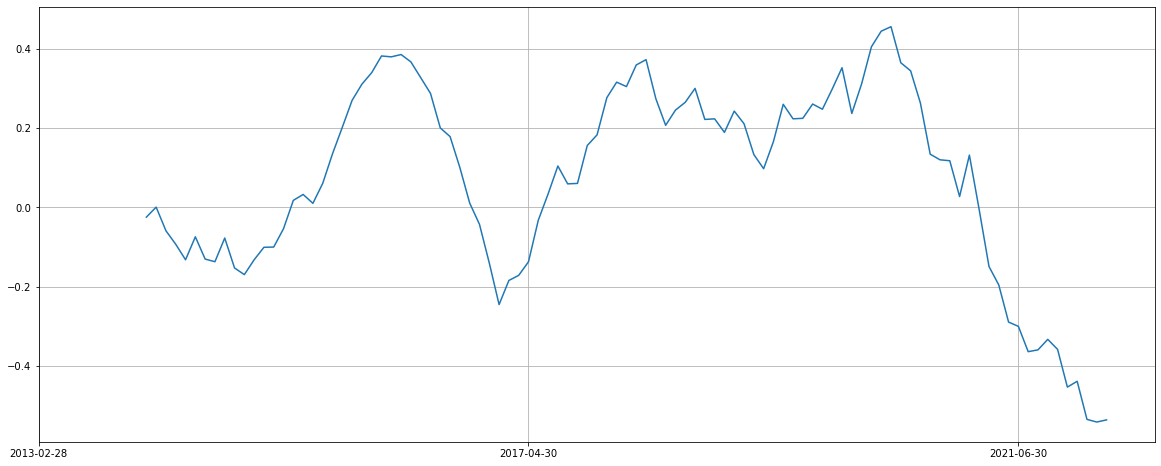

In [159]:
plt.figure(figsize = (20,8))
plt.plot(IC.rolling(12).mean())
#plt.plot(IC)
plt.xticks(np.arange(0,len(IC),50))
plt.grid()
plt.show()

## New Weights Using Linear Weighting Scheme

In [160]:
base_w = np.array([0.026,0.08,0.118,0.062,0.133,0.115,0.281,0.096,0.026,0.026,0.037])

In [161]:
T            = Retdf.shape[0]
New_weights = {}
for i in range(T):
    rank = Retdf.iloc[i][Retdf.iloc[i].isna()==False].rank(ascending = False).dropna().to_numpy().astype(int)
    n    = len(rank)
    l    = np.linspace(1/n, -1/n, num=n).round(2)
    weight = l[rank-1] + base_w
    
    New_weights[i] = weight

## Portfolio Return

Multiply the adjusted weights with the predicted return to calculate predicted portfolio return.

In [125]:
def portfolio_ret(df,weights):
    port_ret = {}
    i        = 0
    while i < df.shape[0]:
        try:
            pred_ret = df.iloc[i].dropna()
            w = weights[i]
            r = np.matmul(w,pred_ret.to_numpy())
            port_ret[i] = r        
        except:
            port_ret[i] = np.nan
        i += 1
    return port_ret

In [162]:
port_ret = portfolio_ret(df.iloc[T1+1:,5:],New_weights)

In [163]:
len(port_ret)

110

In [164]:
df.head(220)

,Date,bcom_ret,cpi_ret,pmi_ret,dxy_ret,Materials_ret,_Industrials_ret,_Consumer_Discretionary_ret,Consumer_Staples_ret,_Health_Care_ret,Financials_ret,Information_Technology_ret,Telecommunication_Services__ret,Utilities_ret,Real_Estate_ret,Energy_ret
0,1995-01-31,-0.010776,0.002003,-0.040070,-0.009804,0.064244,0.052688,0.033880,0.028613,0.011563,0.052696,0.066760,0.005734,0.000942,-0.011090,0.031235
1,1995-02-28,-0.005805,0.002665,-0.054446,-0.021737,0.053224,0.033088,0.030175,0.028865,0.027695,0.001254,0.050385,0.002281,-0.022580,-0.006164,0.050957
2,1995-03-31,0.019684,0.002658,-0.011516,-0.048744,0.012541,0.030675,-0.013433,0.028333,0.024959,0.033539,0.105226,0.021426,0.027722,0.036709,0.027098
3,1995-04-30,0.015482,0.001988,-0.093204,0.002079,0.029633,0.021884,0.044629,0.043040,0.022940,0.074939,0.037986,-0.007054,0.065561,0.014088,0.029913
4,1995-05-31,-0.012037,0.003968,-0.017131,0.007689,0.036621,0.015762,0.026340,0.016143,0.041401,0.003703,0.090244,0.027482,-0.015030,0.007169,-0.036326
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
215,2012-12-31,-0.026135,-0.001727,0.062249,-0.004791,0.043377,0.065059,0.064639,0.064700,0.080727,0.065616,0.020251,0.031235,0.056745,0.034001,0.086518
216,2013-01-31,0.023908,0.000000,0.032136,-0.007045,-0.013020,0.025431,0.015531,0.035422,0.018407,0.017563,0.009999,0.033907,0.018813,0.011712,0.004901
217,2013-02-28,-0.040935,0.002163,-0.038462,0.034618,0.015616,0.013762,0.039585,0.037809,0.050882,0.028220,0.015924,0.024110,0.043104,0.013166,0.019784
218,2013-03-31,0.006660,0.005179,-0.040000,0.012788,0.007000,-0.005818,0.031449,0.031377,0.031765,0.029202,0.010491,0.059933,0.064185,0.068743,-0.014942


In [129]:
sp500 = pd.read_csv('/Users/msstark/Desktop/Brandeis/Field Project/data/SP500.csv')
sp500.set_index('Date',inplace=True)
compare = sp500[(sp500.index > '1995-08-01') & (sp500.index <'2022-05-01')].copy()
compare.columns = ['sp500']
compare.reset_index(inplace = True)

In [165]:
sp500 = pd.read_csv('/Users/msstark/Desktop/Brandeis/Field Project/data/SP500.csv')
sp500.set_index('Date',inplace=True)
compare = sp500[(sp500.index > '2013-02-01') & (sp500.index <'2022-05-01')].copy()
compare.columns = ['sp500']
compare.reset_index(inplace = True)

In [166]:
compare.shape

(110, 2)

In [167]:
compare['port']   = pd.Series(port_ret)
compare.set_index('Date',inplace = True)
compare.head()

,sp500,port
Date,,
2013-03-01,0.035988,0.023605
2013-04-01,0.018086,0.022958
2013-05-01,0.020763,0.020937
2013-06-01,-0.014999,-0.007904
2013-07-01,0.049462,0.042215


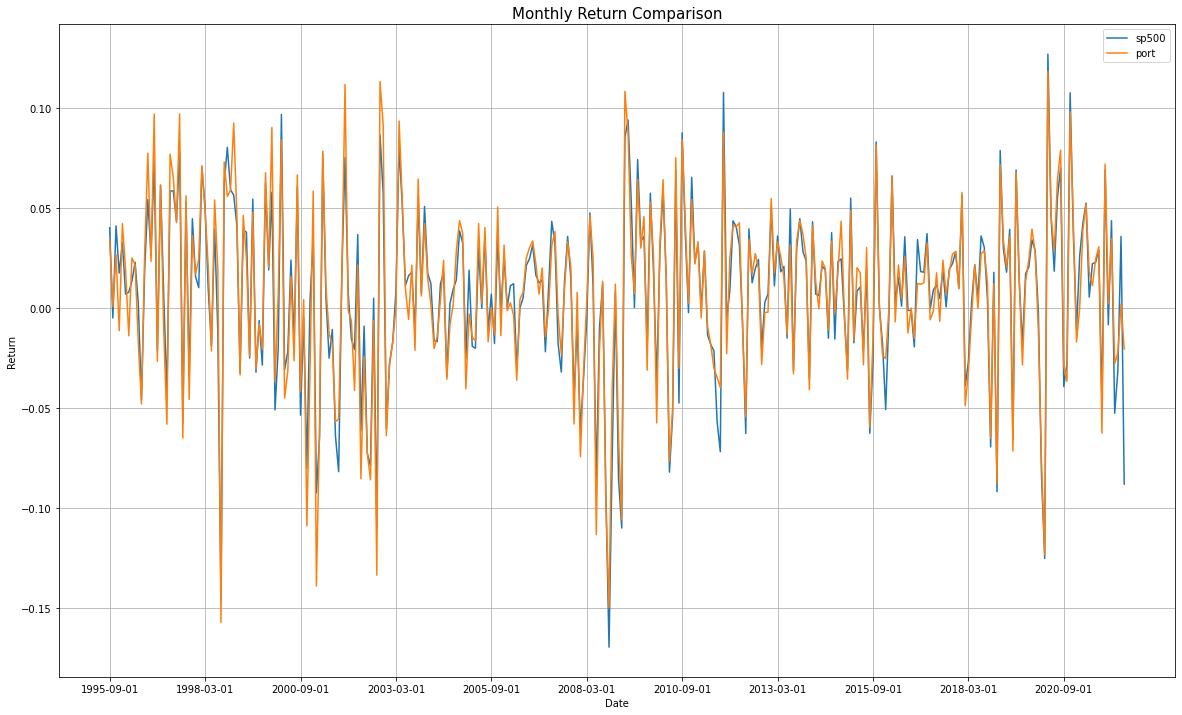

In [132]:
#Train = 6
plt.figure(figsize = (20,12))
plt.plot(compare['sp500'],label = 'sp500',linewidth = 1.5)
plt.plot(compare['port'],label = 'port',linewidth = 1.5)    
# setting xtick frequency
plt.xticks(np.arange(0, len(compare)+1, 30),fontsize = 10)
plt.yticks(fontsize = 10)
plt.title('Monthly Return Comparison',fontsize = 15)
# reference line when corr = 0
#plt.axhline(y = 0,color='grey',linestyle='--')
plt.legend(loc = 'upper right',fontsize = 10)
plt.xlabel('Date',fontsize=10)
plt.ylabel('Return',fontsize=10)
plt.grid()

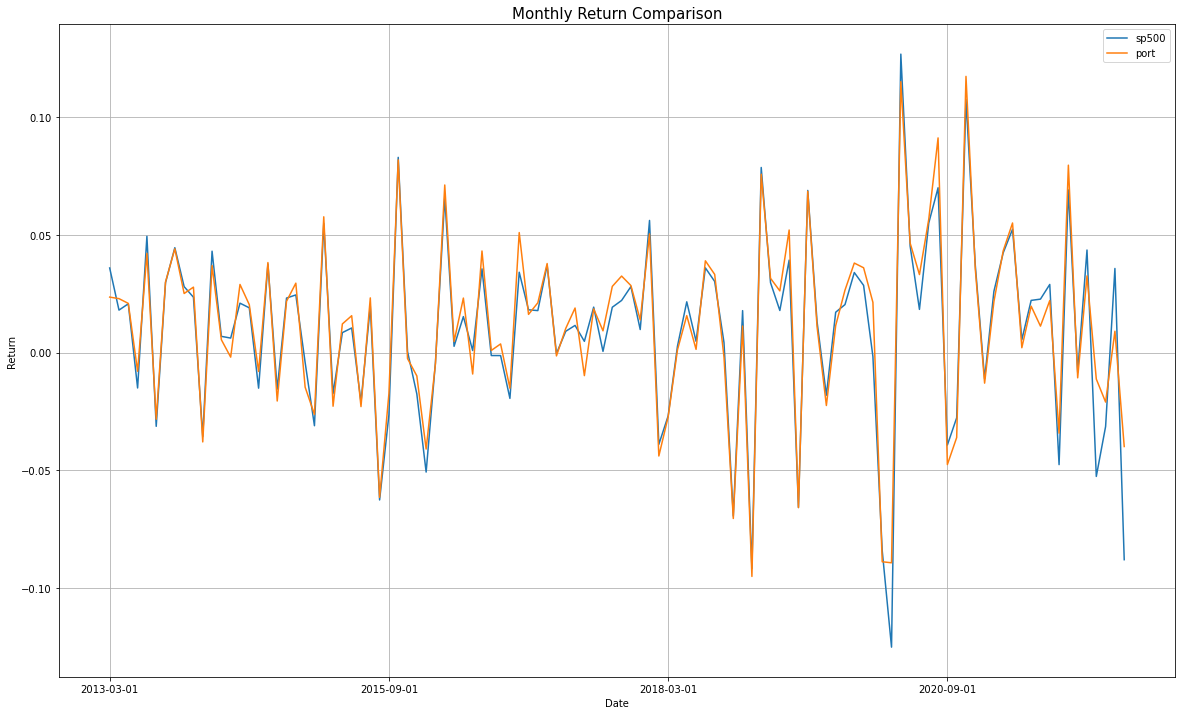

In [168]:
# Train = 216
plt.figure(figsize = (20,12))
plt.plot(compare['sp500'],label = 'sp500',linewidth = 1.5)
plt.plot(compare['port'],label = 'port',linewidth = 1.5)    
# setting xtick frequency
plt.xticks(np.arange(0, len(compare)+1, 30),fontsize = 10)
plt.yticks(fontsize = 10)
plt.title('Monthly Return Comparison',fontsize = 15)
# reference line when corr = 0
#plt.axhline(y = 0,color='grey',linestyle='--')
plt.legend(loc = 'upper right',fontsize = 10)
plt.xlabel('Date',fontsize=10)
plt.ylabel('Return',fontsize=10)
plt.grid()

## Portfolio Analysis

In [133]:
# train = 6
compare.describe()

,sp500,port
count,320.000000,320.000000
mean,0.007226,0.007563
std,0.043851,0.045614
min,-0.169425,-0.157057
25%,-0.017583,-0.017441
50%,0.011830,0.012225
75%,0.035736,0.033594
max,0.126844,0.118221


In [169]:
# train = 216
compare.describe()

,sp500,port
count,110.000000,110.000000
mean,0.009959,0.011863
std,0.039941,0.038517
min,-0.125119,-0.095074
25%,-0.010436,-0.009844
50%,0.017872,0.016008
75%,0.033101,0.033042
max,0.126844,0.117388


### 1. Excess Return

In [32]:
def excess_return(df,benchCol,portCol):
    excess_ret = []
    for i in range(len(df)-12):
        select = df.iloc[i:i+12].copy()
        bench  = select[benchCol]
        port   = select[portCol]
        te     = (port - bench)
        excess_ret.append(te)
    return np.mean(excess_ret)

In [134]:
print('Excess Return(t=6)',excess_return(compare,'sp500','port'))

Excess Return(t=6) 0.0002519626563921443


In [170]:
print('Excess Return(t=216)',excess_return(compare,'sp500','port'))

Excess Return(t=216) 0.0015836400785709604


### 2. Tracking Error

In [34]:
def tracking_error(df,benchCol,portCol):
    tracking_err = []
    for i in range(len(df)-12):
        select = df.iloc[i:i+12].copy()
        bench  = select[benchCol]
        port   = select[portCol]
        te     = np.std(port - bench)
        tracking_err.append(te)
    return np.mean(tracking_err)

In [138]:
print('Tracking Error(t=6)',tracking_error(compare,'sp500','port'))

Tracking Error(t=6) 0.010645368561674105


In [171]:
print('Tracking Error(t=216)',tracking_error(compare,'sp500','port'))

Tracking Error(t=216) 0.006924241161068671


### 3. Information Ratio

$IR = \frac{\alpha_{er}}{\sigma_{er}} $

where:  

$\alpha = R_{port} - R_{f} - \beta (R_{market} - R_{f})$  

$\beta = Correlation(R_{port},R_{market}) \frac{\sigma_{port}}{\sigma_{market}}$

In [36]:
def info_ratio(df,benchCol, portCol, rf):
    df    = df[[benchCol,portCol]].dropna().copy()
    annual_IR = []
    for i in range(len(df)-12):
        select = df.iloc[i:i+12].copy()
        # systematic risk
        beta  = select.cov().to_numpy()[0][1] / select[benchCol].var()
        diff  = select[portCol] - select[benchCol]
        sigma = np.std(diff)
        alpha = select[portCol] - rf - beta * (select[benchCol] - rf)
        IR    = alpha/sigma
        annual_IR.append(IR)
    return np.mean(annual_IR)

In [137]:
print('IR(t=6)',info_ratio(compare,'sp500', 'port', 0.06/12))

IR(t=6) -0.00168519423464004


In [172]:
print('IR(t=216)',info_ratio(compare,'sp500', 'port', 0.06/12))

IR(t=216) 0.14760140772143077


### 4. Sharpe Ratio

In [38]:
def sharpe_ratio(df,portCol,rf):
    annual_SR = []
    for i in range(len(df)-12):
        select = df.iloc[i:i+12].copy()
        portfolio = select[portCol]
        sigma = np.std(portfolio)
        SR = (portfolio - rf)/sigma
        annual_SR.append(SR)
    return np.mean(annual_SR)

In [139]:
print('Sharpe Ratio(t=6)',sharpe_ratio(compare,'port',0.06/12))

Sharpe Ratio(t=6) 0.11412164213665359


In [173]:
print('Sharpe Ratio(t=216)',sharpe_ratio(compare,'port',0.06/12))

Sharpe Ratio(t=216) 0.2448599210674036


### 5. Information Coefficient

In [174]:
def info_coef(df1,df2):
    # total length of the dataframe
    T = df1.shape[0]
    # Information Coefficient at each time point
    ICt = []
    for i in range(T):
        # sector return in each month
        rank1  = df1.iloc[i].rank(ascending = False).dropna().to_numpy()
        
        # ranking for each sector based on the correlation coefficient
        rank2 = df2.iloc[i][(df1.iloc[i].isna()==False).to_list()].rank(ascending = False).dropna().to_numpy()
        # sector number
        n = len(rank1)
        
        numerator = np.matmul(rank1,rank2) - np.sum(rank2)*np.sum(rank1)/n       
        alpha2    = np.sum(np.square(rank2)) - np.square(np.sum(rank2))/n
        rank1_2   = np.sum(np.square(rank1)) - np.square(np.sum(rank1))/n
        denominator = np.sqrt(alpha2 * rank1_2)
        
        # Information coefficient at each predicting point
        ICt.append(numerator/denominator)
    
    annual_IC = []
    for j in range(len(ICt) - 12):
        select = ICt[j:j+12]
        annual_IC.append(np.mean(select))        
   
    return np.mean(annual_IC)

In [142]:
df1 = pd.DataFrame.from_dict(New_weights).T
df2 = df.iloc[7:,5:]
print('IC(t=6)',info_coef(df1,df2))

IC(t=6) -0.0004048428788498015


In [175]:
df1 = pd.DataFrame.from_dict(New_weights).T
df2 = df.iloc[217:,5:]
print('IC(t=216)',info_coef(df1,df2))

IC(t=216) 0.09850730356817633


### 6. Hit Rate

In [45]:
def hit_rate(df, benchCol,portCol):
    annual_hit = []
    for i in range(len(df)-12):       
        diff = (df[portCol] - df[benchCol]) > 0
        annual_hit.append(np.mean(diff))
    return np.mean(annual_hit)

In [143]:
print('Hit Rate of adjusted portfolio(t=6): ',hit_rate(compare,'sp500','port'))


Hit Rate of adjusted portfolio(t=6):  0.5031249999999999


In [176]:
print('Hit Rate of adjusted portfolio(t=216): ',hit_rate(compare,'sp500','port'))

Hit Rate of adjusted portfolio(t=216):  0.5363636363636363


### 4. Maximum Drawdown

$MDD = Trough Value - Peak Value$

In [47]:
def MDD(df,col):
    port = df[col].dropna().copy()
    peak = port[0]
    mdd  = np.inf
    for i in range(len(port)-12):
        tmp  = port.iloc[i:i+12]
        peak = max(tmp)
        peak_ind = tmp[tmp == peak].index[0]
        trough   = min(tmp[tmp.index >= peak_ind])
        mdd      = min((trough - peak)/peak,mdd)
        
    return mdd
    

In [144]:
print('Maximum Drawdown of sp500(t=6): ',MDD(compare,'sp500'))
print('Maximum Drawdown of adjusted portfolio(t=6): ',MDD(compare,'port'))


Maximum Drawdown of sp500(t=6):  -4.563328946548292
Maximum Drawdown of adjusted portfolio(t=6):  -4.235504961682937


In [177]:
print('Maximum Drawdown of sp500(t=216): ',MDD(compare,'sp500'))
print('Maximum Drawdown of adjusted portfolio(t=216): ',MDD(compare,'port'))


Maximum Drawdown of sp500(t=216):  -2.815160085969353
Maximum Drawdown of adjusted portfolio(t=216):  -2.8832388924808825


In [178]:
compare['sp500_Accu'] = (1+compare['sp500']).cumprod()
compare['portAccu'] = (1+compare['port']).cumprod()

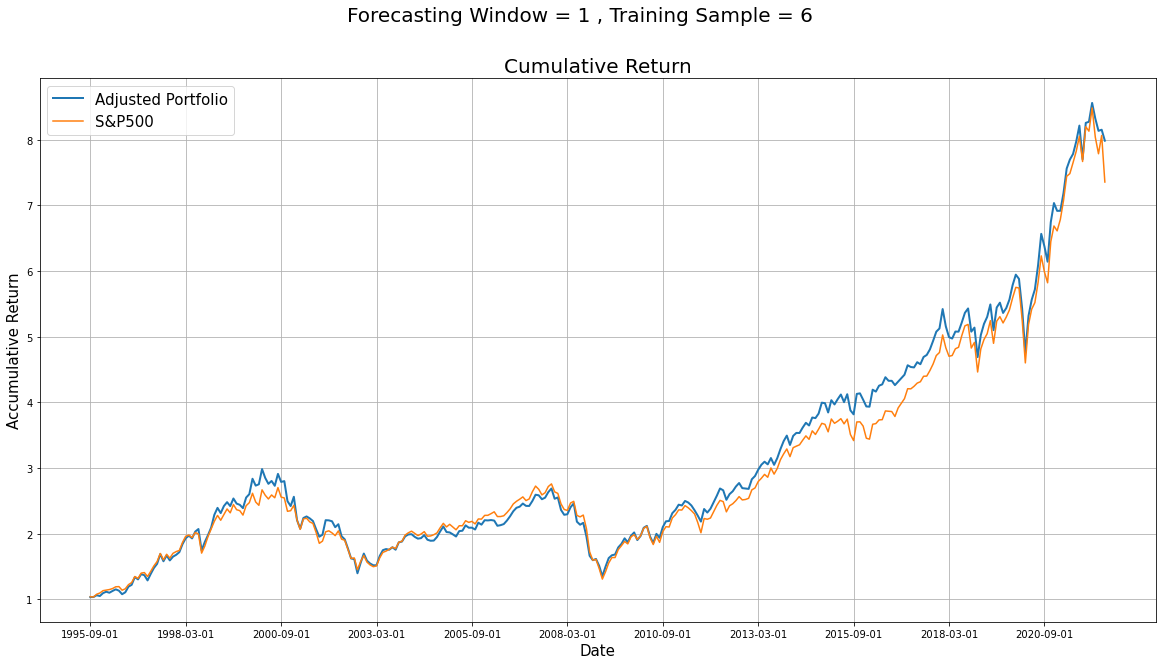

In [147]:
plt.figure(figsize = (20,10))
plt.plot(compare['portAccu'],label = 'Adjusted Portfolio',linewidth = 2)
plt.plot(compare['sp500_Accu'],label = 'S&P500')
plt.xticks(np.arange(0,len(compare),30))
plt.xlabel('Date',fontsize = 15)
plt.ylabel('Accumulative Return',fontsize = 15)
plt.legend(loc = 'upper left',fontsize = 15)
plt.suptitle('Forecasting Window = 1 , Training Sample = 6',fontsize = 20)
plt.title('Cumulative Return',fontsize = 20)
plt.grid()
plt.show()

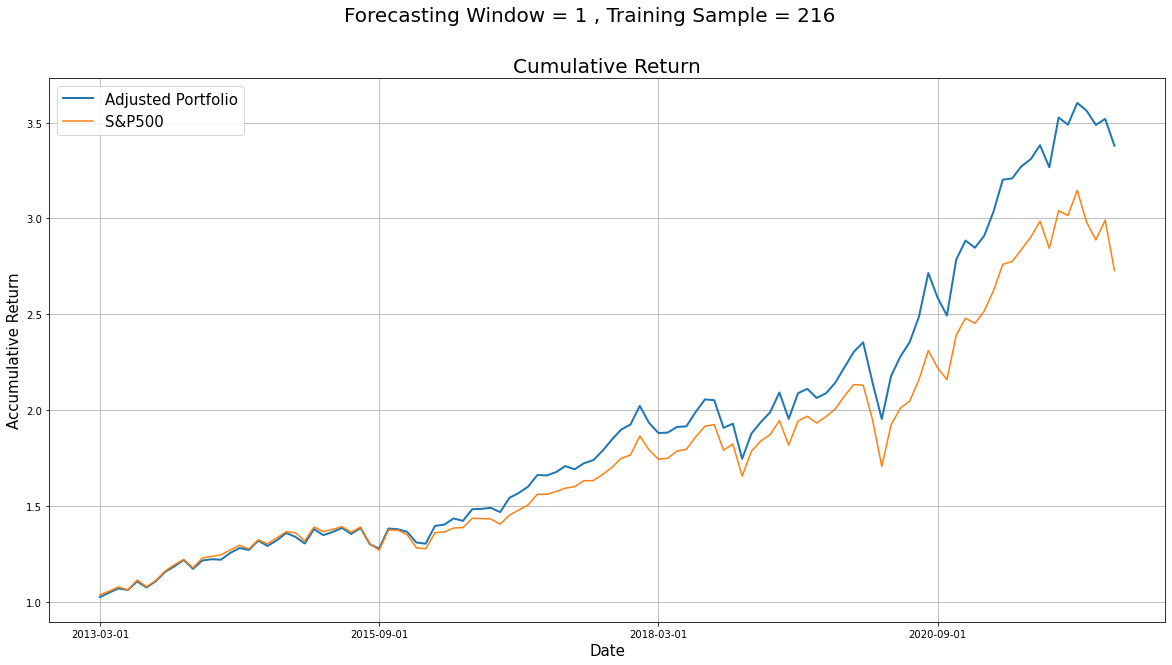

In [180]:
plt.figure(figsize = (20,10))
plt.plot(compare['portAccu'],label = 'Adjusted Portfolio',linewidth = 2)
plt.plot(compare['sp500_Accu'],label = 'S&P500')
plt.xticks(np.arange(0,len(compare),30))
plt.xlabel('Date',fontsize = 15)
plt.ylabel('Accumulative Return',fontsize = 15)
plt.legend(loc = 'upper left',fontsize = 15)
plt.suptitle('Forecasting Window = 1 , Training Sample = 216',fontsize = 20)
plt.title('Cumulative Return',fontsize = 20)
plt.grid()
plt.show()

## Fixed Reg

In [53]:
window = 1
df_select = df.copy()
df_select.iloc[:,1:5] = df_select.iloc[:,1:5].shift(window)
df_select = df_select[window:].reset_index().drop('index',axis = 1)
df_select.head()

,Date,bcom_ret,cpi_ret,pmi_ret,dxy_ret,Materials_ret,_Industrials_ret,_Consumer_Discretionary_ret,Consumer_Staples_ret,_Health_Care_ret,Financials_ret,Information_Technology_ret,Telecommunication_Services__ret,Utilities_ret,Real_Estate_ret,Energy_ret
0,1995-02-28,-0.010776,0.002003,-0.040070,-0.009804,0.053224,0.033088,0.030175,0.028865,0.027695,0.001254,0.050385,0.002281,-0.022580,-0.006164,0.050957
1,1995-03-31,-0.005805,0.002665,-0.054446,-0.021737,0.012541,0.030675,-0.013433,0.028333,0.024959,0.033539,0.105226,0.021426,0.027722,0.036709,0.027098
2,1995-04-30,0.019684,0.002658,-0.011516,-0.048744,0.029633,0.021884,0.044629,0.043040,0.022940,0.074939,0.037986,-0.007054,0.065561,0.014088,0.029913
3,1995-05-31,0.015482,0.001988,-0.093204,0.002079,0.036621,0.015762,0.026340,0.016143,0.041401,0.003703,0.090244,0.027482,-0.015030,0.007169,-0.036326
4,1995-06-30,-0.012037,0.003968,-0.017131,0.007689,0.026904,0.044611,0.032983,-0.000085,0.046298,0.026708,0.061420,0.034389,-0.003391,0.007297,0.032717


In [54]:
def Static_Reg(X_train,y_train,X_test,y_test):
    x   = sm.add_constant(X_train.to_numpy())
    x_t = sm.add_constant(X_test.to_numpy())
    
    y = y_train
    uni_reg = sm.OLS(y,x).fit()
    R2 = uni_reg.rsquared
    InPred  = uni_reg.predict(x)
    Outpred = uni_reg.predict(x_t)
    InRMSE  = RMSE(y,InPred)
    OutRMSE = RMSE(y_test,Outpred)
    return uni_reg,R2,InPred,Outpred,InRMSE,OutRMSE

In [55]:
test_size = len(df_select)//3
df_train  = df_select.iloc[:-test_size]
df_test   = df_select.iloc[-test_size:]

In [56]:
X_col = df.columns[1:5]
y_col = df.columns[5:]
X_train = df_train[X_col]
X_test  = df_test[X_col]

model1     = []
Prediction = {}
Result1    = {}

for i in range(len(y_col)):
    y_train = df_train[y_col[i]].to_list()
    y_test  = df_test[y_col[i]].to_list()
    uni_reg,R2,InPred,Outpred,InRMSE,OutRMSE = Static_Reg(X_train,y_train,X_test,y_test)
    model1.append(uni_reg)
    
    Prediction[i] = np.concatenate([InPred,Outpred])
    Result1[i]    = [R2,InRMSE,OutRMSE]

In [57]:
col = df_select.columns[5:].to_list()
df_pred = pd.DataFrame.from_dict(Prediction)
#df_pred = df_pred[1:].copy()
df_pred.columns = col
df_pred.index   = df_select.Date#[1:]
df_pred.head()

,Materials_ret,_Industrials_ret,_Consumer_Discretionary_ret,Consumer_Staples_ret,_Health_Care_ret,Financials_ret,Information_Technology_ret,Telecommunication_Services__ret,Utilities_ret,Real_Estate_ret,Energy_ret
Date,,,,,,,,,,,
1995-02-28,-0.004430,-0.002397,0.004233,0.002400,0.003674,-0.010607,0.006792,0.003651,0.004473,-0.009960,-0.001154
1995-03-31,-0.007968,-0.004863,0.002773,0.002262,0.002501,-0.015233,0.004353,0.003463,0.004631,-0.015100,-0.003989
1995-04-30,-0.002476,-0.003096,0.001106,0.006541,0.002253,-0.006027,0.001151,-0.000974,0.000435,-0.007436,-0.000950
1995-05-31,-0.006186,0.001841,0.012265,0.002714,0.009409,-0.012548,0.017263,0.015912,0.010752,-0.017883,-0.001986
1995-06-30,0.003275,0.007842,0.006895,0.007182,0.008854,0.003563,0.006679,0.003310,0.006621,0.006404,0.011779


In [58]:
base_w = np.array([0.026,0.08,0.118,0.062,0.133,0.115,0.281,0.096,0.026,0.026,0.037])

In [59]:
T            = df_pred.shape[0]
New_weights1 = {}
for i in range(T):
    rank = df_pred .iloc[i][df_pred.iloc[i].isna()==False].rank(ascending = False).dropna().to_numpy().astype(int)
    n    = len(rank)
    l    = np.linspace(1/n, -1/n, num=n).round(2)
    weight = l[rank-1] + base_w
    
    New_weights1[i] = weight

In [60]:
def portfolio_ret(df,weights):
    port_ret = {}
    i        = 0
    while i < df.shape[0]:
        try:
            pred_ret = df.iloc[i].dropna()
            w = weights[i]
            r = np.matmul(w,pred_ret.to_numpy())
            port_ret[i] = r        
        except:
            port_ret[i] = np.nan
        i += 1
    return port_ret

In [61]:
port_ret1 = portfolio_ret(df_select.iloc[:,5:],New_weights1)

In [181]:
sp500 = pd.read_csv('/Users/msstark/Desktop/Brandeis/Field Project/data/SP500.csv')
sp500.set_index('Date',inplace=True)
compare1 = sp500[(sp500.index > '1995-02-01') & (sp500.index <'2022-05-01')].copy()
compare1.columns = ['sp500']
compare1.reset_index(inplace = True)

compare1['port']   = pd.Series(port_ret1)
compare1.set_index('Date',inplace = True)

compare_test = compare1[compare1.index > '2013-02-01'].copy()
compare_test

,sp500,port
Date,,
2013-03-01,0.035988,0.023605
2013-04-01,0.018086,0.023613
2013-05-01,0.020763,0.023699
2013-06-01,-0.014999,-0.007904
2013-07-01,0.049462,0.042215
...,...,...
2021-12-01,0.043613,0.037300
2022-01-01,-0.052585,-0.003766
2022-02-01,-0.031360,-0.019043


In [182]:
compare_test['rollingAccu'] = compare[compare.index > '2013-02-01']['port'].copy()
compare_test['port_rollRegAccu'] = (1+compare_test['rollingAccu']).cumprod()
compare_test['sp500Accu'] = (1+compare_test['sp500']).cumprod()
compare_test['port_fixRegAccu'] = (1+compare_test['port']).cumprod()

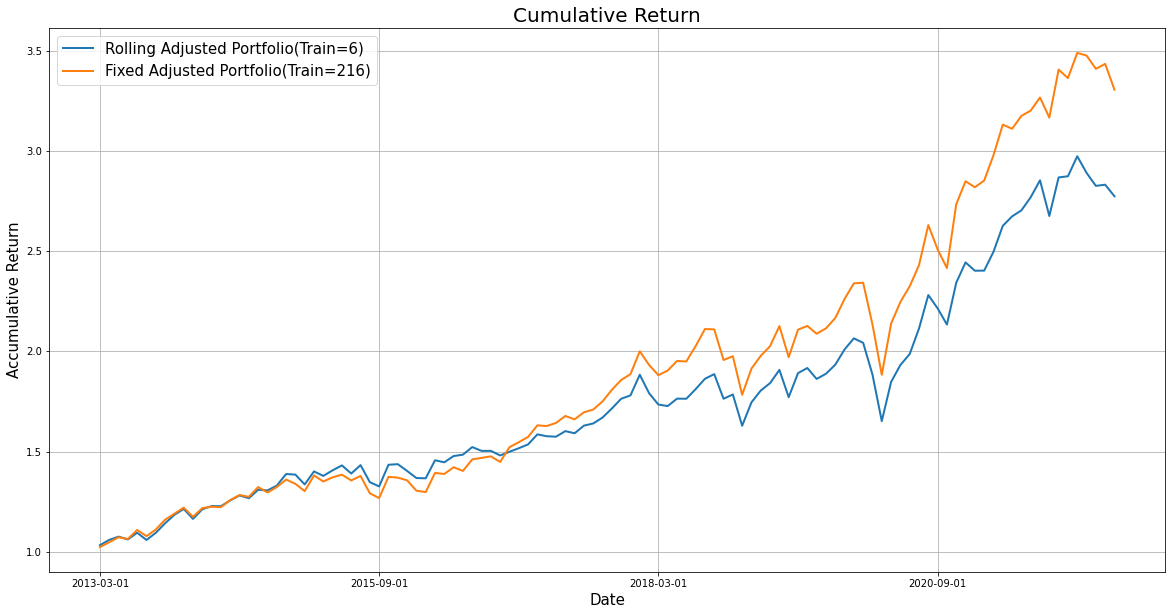

In [76]:
plt.figure(figsize = (20,10))
#plt.plot(compare_test['sp500Accu'],label = 'S&P500',linewidth = 2)
plt.plot(compare_test['port_rollRegAccu'],label = 'Rolling Adjusted Portfolio(Train=6)',linewidth = 2)
plt.plot(compare_test['port_fixRegAccu'],label = 'Fixed Adjusted Portfolio(Train=216)',linewidth = 2)
#plt.plot(compare['sp500_Accu'],label = 'S&P500')
plt.xticks(np.arange(0,len(compare_test),30))
plt.xlabel('Date',fontsize = 15)
plt.ylabel('Accumulative Return',fontsize = 15)
plt.legend(loc = 'upper left',fontsize = 15)
#plt.suptitle('Forecasting Window = 1 , Training Sample = 216',fontsize = 20)
plt.title('Cumulative Return',fontsize = 20)
plt.grid()
plt.show()

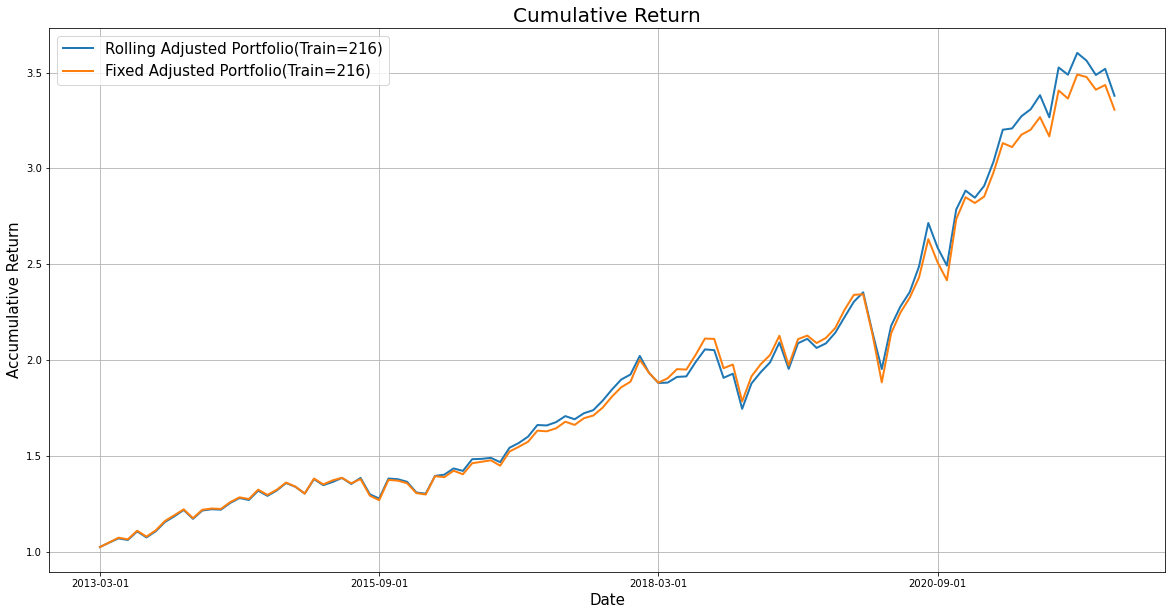

In [183]:
plt.figure(figsize = (20,10))
#plt.plot(compare_test['sp500Accu'],label = 'S&P500',linewidth = 2)
plt.plot(compare_test['port_rollRegAccu'],label = 'Rolling Adjusted Portfolio(Train=216)',linewidth = 2)
plt.plot(compare_test['port_fixRegAccu'],label = 'Fixed Adjusted Portfolio(Train=216)',linewidth = 2)
#plt.plot(compare['sp500_Accu'],label = 'S&P500')
plt.xticks(np.arange(0,len(compare_test),30))
plt.xlabel('Date',fontsize = 15)
plt.ylabel('Accumulative Return',fontsize = 15)
plt.legend(loc = 'upper left',fontsize = 15)
#plt.suptitle('Forecasting Window = 1 , Training Sample = 216',fontsize = 20)
plt.title('Cumulative Return',fontsize = 20)
plt.grid()
plt.show()